# Linear Predictive Coding

Importing the required packages

In [216]:
import numpy as np
from scipy.signal.windows import hann, hamming
import math
from matplotlib import pyplot as plt
import soundfile as sf
import librosa as lb
import scipy
from scipy import signal

### 1. Reading the speech signal

Reading the input signal and storing its amplitude in input_speech and sampling frequency in fs

In [218]:
input_speech, fs = sf.read('/Users/rajeshr/Desktop/should.wav')
print(input_speech, fs, len(input_speech))

[0.00039673 0.00045776 0.00012207 ... 0.00082397 0.00033569 0.00018311] 10000 10165


### 2. Generating window function

Generating Hamming window: Hamming/Hanning window is preffered over rectangular windows as it preserves the uniformity of speech signal

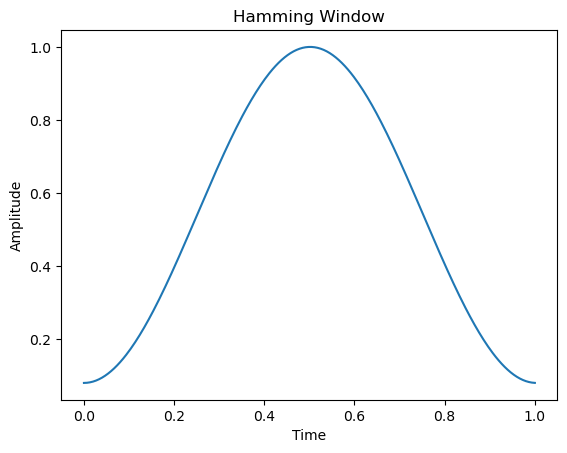

In [219]:
sym = False
wind = hamming(math.floor(0.03*fs), sym)

x = np.arange(len(wind))
plt.title('Hamming Window')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(x/max(x), wind)
plt.show()

### 3. Creating the block of frames from the Speech Input

Short time processing of speech is much useful as the energy, power spectrum varies widely

In [220]:
def FrameBlocks(sig, window, O = 0.5):
    
    n = len(sig)
    nw = len(window)
    step = math.floor(nw * (1 - O))
    nb = math.floor((n - nw) / step) + 1
    frames = np.zeros((nb, nw))
    for i in range(nb):
        offset = i * step
        frames[i, :] = window * sig[offset : nw + offset]

    return frames

In [221]:
frames = FrameBlocks(input_speech, wind)
print('No of frames: ', len(frames))

No of frames:  66


Plotting the FFT Spectrum

In [222]:
def plot_spectrum(frames, frame_no):
    frame = frames[frame_no]
    dft_frame = np.fft.fft(frame)
    
    x = np.arange(len(frame)/2)
    
    # Getting DFT Spectrum
    y1 = np.log(abs(dft_frame[:int(len(frame)/2)]))
    
    
    plt.title('DFT Spectrum of frame: '+str(frame_no))
    plt.xlabel('frequency in π units')
    plt.ylabel('log|X(w)|')
    plt.plot(x/max(x),y1)
    plt.savefig('/Users/rajeshr/Desktop/dft_frame'+str(frame_no)+'.png')
    plt.show()

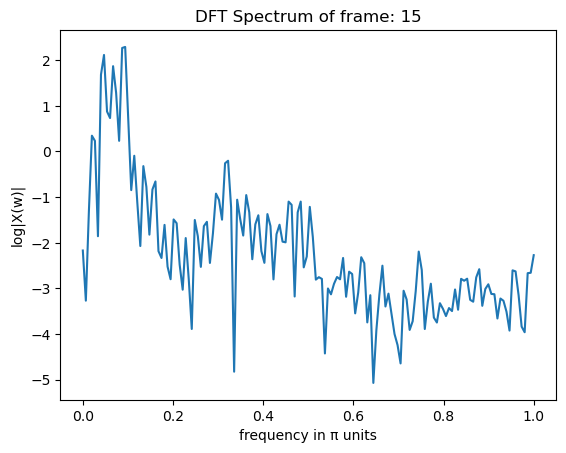

In [223]:
plot_spectrum(frames, 15)

### 4. Computing the LPC Spectrum Envelope

In [224]:
def plotLPC(frames, frame_no, p=6):
    frame = frames[frame_no]
    
    #LPC Spectrum
    a = lb.lpc(frame, p)
    b = 2
    w, h = signal.freqz(b, a)
    
    #FFT of frame
    fft_frame = np.log10(abs(np.fft.fft(frame)))
    fft_frame = fft_frame[:int(len(fft_frame)/2)]
    x = np.arange(len(fft_frame))
    
    
    plt.title('Spectrum Analysis of frame: '+str(frame_no))
    plt.xlabel('frequency in π units')
    plt.ylabel('log|X(w)|')
    
    
    plt.plot(w/max(w), np.log10(abs(h))-1)
    plt.plot(x/max(x), fft_frame)
    
    plt.legend(['LPC Envelope','DFT Spectrum'])
    plt.savefig('/Users/rajeshr/Desktop/spect_analysis'+str(frame_no)+'.png')
    plt.show()
    
    return a
  

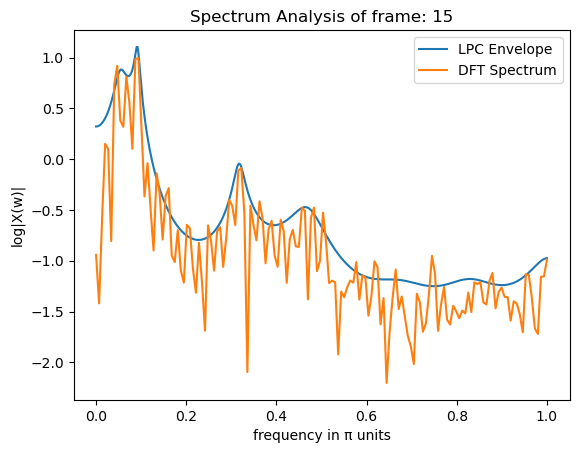

In [225]:
coefficients = plotLPC(frames, 15, 16)

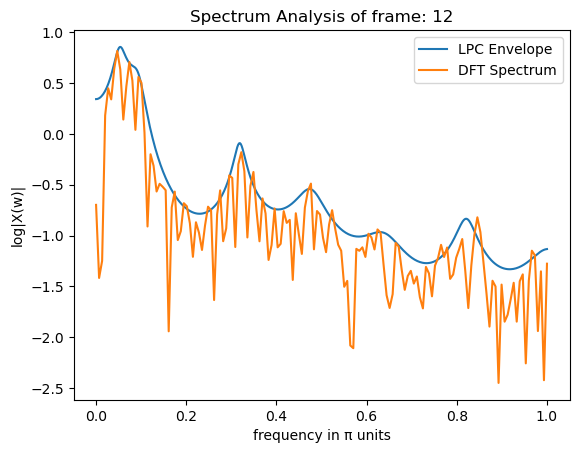

In [226]:
coefficients = plotLPC(frames, 12, 16)

### 5. Creating Residual Signal and Synthetic Speech Frames

In [168]:
def create_synthetic_frames(frames, coefficients):
    synthetic_frames = []
    poles = 1
    for frame in frames:
        residual = signal.lfilter(coefficients, poles, frame)
        synthetic = signal.lfilter([1], coefficients, residual)
        synthetic_frames.append(synthetic)
        
    return synthetic_frames


In [171]:
synthetic_frames = create_synthetic_frames(frames, coefficients)
print(len(synthetic_frames))

66


### 6. Re-Adding the synthetic speeech frames into single file

In [227]:
def AddFrameBlocks(Blocks, window, O = 0.5):
    count, nw = Blocks.shape
    step = np.floor(nw * O)

    n = (count-1) * step + nw
    x = np.zeros((int(n), ))

    for i in range(count):
        offset = int(i * step)
        x[offset : nw + offset] += Blocks[i, :]

    return x

In [228]:
reconstruted = AddFrameBlocks(np.array(synthetic_frames), wind)
print(len(reconstruted))

10050


### 7. Writing the resultant audio file

In [178]:
sf.write('/Users/rajeshr/Desktop/reconstruted.wav', reconstruted, fs)